<a href="https://colab.research.google.com/github/jb-diplom/humour-detection/blob/main/notebooks/NLM_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Effect of Humour in Political Messaging: 
An investigation combining fine-tuned neural language models and social network analysis<br>
by<br>
Janice Butler: University of Amsterdam, Master Thesis 2021

## Introduction
This notebook implements the fine-tuning of various neural language models (NLMs) based on a new corpus of annotated humorous texts.
Two classifications are made

1.   Degree of humour
2.   Comic styles

## Method 
The training script is modified from [run_glue.py](https://huggingface.co/transformers/examples.html#glue). 
The training is automatically tracked in the Weights & Biases dashboard. 

### Supervised Fine-Tuning

This script fine-tunes NMLs on corpora scraped from several sub-reddits:
* https://www.reddit.com/r/Jokes/
* https://www.reddit.com/r/satire/
* https://www.reddit.com/r/Showerthoughts/
* https://www.reddit.com/r/SurrealHumor

and from twitter:
* https://twitter.com/midnight

For non-humorous texts an equal amount of data was taken from these serious news outlets:
* https://twitter.com/AP
* https://twitter.com/BBCworld
* https://twitter.com/ITN
* https://twitter.com/ITVnews
* https://twitter.com/SkyNewsPolitics
* https://twitter.com/TheEconomist

### Annotation
The reddit data is automatically annotated into 5 grades  according to the up-votes per subreddit. All other annotation was achieved through manual categorisation, for humour degree on the https://twitter.com/midnight tweets and in all cases for type of humour. The categories being:
* Serious
* Fun
* Benevolent humour
* Wit
* Nonsense
* Irony
* Satire
* Sarcasm
* Cynicism

## Install dependencies

Pre-Trained Neural Language Models (NLMs) are taken from [the repository at Huggingface](https://huggingface.co/models). The generic Huggingface [Transformers API](https://huggingface.co/transformers/)  is used throughout for fine-tuning and the [Huggingface Pipeline API](https://huggingface.co/transformers/main_classes/pipelines.html) is taken for easy utilisation of the finished models

### NLM Training-Performance Monitoring
During fine-tuning a multitude of parameters are relayed to a data-base at https://wandb.ai/site. Additionally the fine-tuned model and all resultant meta-data for later cataloging of results and use with the model are recorded in projects defined [here](https://wandb.ai/jb-diplom) 
 

```
TODO: add screenshot loaded from GIT
```



Install the Hugging Face transformers and Weights & Biases libraries, and the dataset and training script for humour fine-tuning.

## Installation and Import of Required Packages and Libraries

The dependencies are as follows:


* Huggingface framework for loading and training models, preprocessing of data
* Optionally install transformers datasets, but not needed if own data/project data is being used
* Wandb is used for visualization of results on the project dashboard https://wandb.ai/jb-diplom/janice-demo
* sentencepiece is required for deberta models
* General purpose libraries (os, glob, pandas, numpy)
* GUI and visualization libraries (data_table, ipywidgets, plotly, tqdm, matplotlib
* For calculating accuracy of fine-tuned models and visualizing the results , sklearn.metrics is used



In [2]:
#@markdown Do imports
!pip install transformers -qq           # huggingface framework for loading and training models, preprocessing of data
# Uncomment following line to carry out benchmark tests with hf datasets
!pip install transformers datasets -qq  # currently transformers datasets --> add own data
!pip install wandb -qq                  # for visualization of results on the project dashboard https://wandb.ai/jb-diplom/janice-demo
!pip install sentencepiece              # required for deberta
!pip install chart_studio
# this was the basis for the inital imlementation
# !wget https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py -qq

# Weights and Biases logging of training metrics and archiving of training results
import wandb

# General purpose libraries
from   google.colab import drive
import glob
import os
import pandas as pd
import numpy as np
import datetime 

# Visualization libraries
%load_ext google.colab.data_table
from   google.colab import data_table
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
from   tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt # For multi plots

# Hugging face API for loading pre-trained models, fine-tuning and utilization
import transformers
from   transformers import AutoModelForSequenceClassification, AutoConfig, pipeline

# Stuff for calculating accuracy of fine-tuned models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import metrics

# Stuff for displaying metrics of fine-tuned models
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

     |████████████████████████████████| 2.3MB 6.8MB/s 
     |████████████████████████████████| 3.3MB 50.0MB/s 
     |████████████████████████████████| 901kB 67.1MB/s 
     |████████████████████████████████| 225kB 7.7MB/s 
     |████████████████████████████████| 245kB 56.8MB/s 
     |████████████████████████████████| 112kB 74.8MB/s 
     |████████████████████████████████| 1.8MB 8.2MB/s 
     |████████████████████████████████| 133kB 62.8MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 174kB 63.9MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 1.2MB 9.7MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 


## API Key
The following calls registers this run at Weights and Biases github unless a session is already active.
Optionally, we can set environment variables to customize W&B logging. See [documentation](https://docs.wandb.com/library/integrations/huggingface).

### Google Drive
The project data is hosted on GDrive to enable an easy interface with [Google Colab](https://colab.research.google.com/). The training data and results are taken from and stored to directories on GDrive, which has to be mounted and requires appropriate credentials.

In [3]:
#@markdown Connect to wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
#@markdown Mount GDrive
drive.mount('/content/gdrive',True)
file_list = glob.glob("/content/gdrive/MyDrive/ColabNotebooks/Visualization/data/*")

Mounted at /content/gdrive


In [6]:
#@markdown Set some global values for consistency of output styling
plot_bgcolor='rgb(150,150,160)'
cmap='viridis'
color_palette_r = px.colors.sequential.Viridis_r
color_palette   = px.colors.sequential.Viridis

# Specify Parameters and Train Model

Here you can choose which pre-trained NL model to fine-tune. Further options are:

*   Which training-data to use
*   Which project to save run-time data to
*   The GLUE-Task to use
*   Initial learning rate
*   Number of epochs to train
*   Stepsize for logging
*   Whether to freeze layers
*   Testrun with mini dataset or not









In [40]:
#@title Enter Parameters for Training { vertical-output: true, form-width: "50%", display-mode: "form" }

#@markdown Specify Parameters for Training
#@markdown ---

# Take viable names from https://huggingface.co/transformers/pretrained_models.html
Comment = "ernie-tiny-htype_5e" #@param {type:"string"}
Model = "nghuyong/ernie-tiny" #@param ["bert-base-uncased", "distilbert-base-uncased", "gpt2", "distilgpt2", "gpt2-medium", "xlnet-base-cased", "roberta-base", "distilroberta-base", "t5-base", "microsoft/deberta-base", "google/electra-base-discriminator", "google/electra-large-discriminator", "vinai/bertweet-base", "nghuyong/ernie-tiny", "nghuyong/ernie-2.0-large-en", "nghuyong/ernie-2.0-en", "distilgpt2", "gpt2-large"] {allow-input: true}
GLUE_Task = "" #@param ["", "cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli", "GPT2"]
Initial_Learn_Rate = 2e-5 #@param {type: "number"}

NrEpochs =   5#@param {type: "number"}
Do_Train = True #@param {type:"boolean"}
Do_Eval = True #@param {type:"boolean"}
Do_Predict = True #@param {type:"boolean"}
 

#@markdown ---
#@markdown Parameters for Quick Tests
#@markdown ---
do_quick_test = False #@param {type:"boolean"}
Freeze_Layers = False #@param {type:"boolean"}
max_train_samples = 20000 #@param {type:"slider", min:100, max:50000, step:100}
max_val_samples = 2000 #@param {type:"slider", min:10, max:10000, step:10}
max_test_samples = 2000 #@param {type:"slider", min:10, max:10000, step:10}
#Percent_of_Trainingdata_to_use = 10 #@param {type:"slider", min: 5, max:100, step:5}

#@markdown ---
#@markdown Visualization Parameters
#@markdown ---

Do_Visualization = False #@param {type:"boolean"}
WandB_Project = "janice-final" #@param ["thesis", "thesis-test-runs", "humour-type", "humour degree", "binary humour degree", "janice-final"] {allow-input: true}
Logging_Steps = 20 #@param {type:"slider", min:10, max:100, step:10}

#@markdown Choose Files for Training 
#@markdown ---
file_ext = ".tsv" #@param [".tsv", ".csv", ".json"] {allow-input: true}
own_modelid=Comment + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S').replace(' ','_').replace(':','.')
print ("New Model ID:", own_modelid)

New Model ID: ernie-tiny-htype_5e2021-05-27_21.41.29


In [35]:
#@markdown Which files would you like to use for traiing the NLM?

dir_list = glob.glob("/content/gdrive/MyDrive/ColabNotebooks/Visualization/*/")
dir_choice = widgets.Dropdown(options=dir_list,value=dir_list[0])
# file_list = glob.glob("/content/gdrive/MyDrive/ColabNotebooks/Visualization/data/*"+ file_ext)
# file_list = glob.glob("/content/gdrive/MyDrive/ColabNotebooks/Visualization/msc_data/*"+ file_ext)
file_list = glob.glob("/content/gdrive/MyDrive/ColabNotebooks/Visualization/midnight/*"+ file_ext)

file_list.insert(0,"")
train_file = widgets.Dropdown(options=file_list,value="")
validation_file = widgets.Dropdown(options=file_list,value="")
test_file = widgets.Dropdown(options=file_list,value="")

items = [widgets.Label(value="Source Directory"),
         widgets.Label(value= "Training"),
         widgets.Label(value="Validation"),
         widgets.Label(value="Test")]

left_box = widgets.VBox([items[0], items[1], items[2], items[3]],width='10%')
right_box = widgets.VBox([dir_choice,train_file,validation_file,test_file],width='80%')
file_pickers=widgets.HBox([left_box, right_box], width='100%')
# file_pickers.overflow_x = 'auto'
right_box.overflow_x = 'auto'

def updateDoclist(b):
    train_file.options=glob.glob(dir_choice.value + "*train*" + file_ext)
    validation_file.options=glob.glob(dir_choice.value + "*dev*" + file_ext)
    test_file.options=glob.glob(dir_choice.value + "*test*" + file_ext)

dir_choice.observe(updateDoclist, names='value')
display(file_pickers)
updateDoclist(None)
do_restart = False

In [9]:
#@markdown Optionally specify the restart of an aborted run
#@markdown ---

do_restart = False #@param {type:"boolean"}
specify_model_path = "/content/gdrive/MyDrive/ColabNotebooks/SavedModels/" #@param {type:"string"}

#@markdown **Checkpoint Name** (e.g. `checkpoint-12000`)
specify_checkpoint = "checkpoint-35000" #@param {type:"string"}

#@markdown ---
#@markdown **Model Name**<br>
#@markdown Fetch model Name from the W & B workspace e.g. [here](https://wandb.ai/jb-diplom/janice-final/table?workspace=user-jb-diplom) <br>
#@markdown Should be of the form <Comment> + <Timestamp> (e.g. `electra-L-htype_balanced20e2021-05-16_07.13.44`)
original_modelname = '' #@param {type:"string"}

In [42]:
os.environ['TRAINING_FILE']=train_file.value
os.environ['VALID_FILE']=validation_file.value
os.environ['TEST_FILE']=test_file.value
os.environ['WANDB_PROJECT']=WandB_Project 
os.environ['WANDB_WANDB_TAGS']=train_file.value # can add comma separated additions, here
os.environ['WANDB_JOB_TYPE']=("Testrun" if do_quick_test else "Fullrun")
os.environ['WANDB_LOG_MODEL'] = 'true'  # saving the model to wandb
os.environ['WANDB_RUN_ID'] = own_modelid  # set own id to allow reuse in next cell

os.environ['GLUE_TASK_NAME']=GLUE_Task
os.environ['TRAIN_EPOCHS']=str(NrEpochs)
os.environ['MODEL']=Model
os.environ['LR']=str(Initial_Learn_Rate)
os.environ['LS']=str(Logging_Steps)
os.environ['RUNNAME']=Comment
os.environ['REPORT_TO']="wandb"
os.environ['OUTPUT_DIR']="/content/gdrive/MyDrive/ColabNotebooks/SavedModels/"+Model
os.environ['WANDB_WATCH']="all"
os.environ['WANDB_RESUME']="auto"
os.environ['SAVE_STEPS']="5000" # big step to avoid filling disk quota
os.environ['SAVE_LIMIT']="1"    # only one backup (let's live dangeraously but save space)
os.environ['BATCH_SIZE']="128"    
os.environ['SEQ_LENGTH']="256"    

if do_restart:
  # to restart from checkpoint use following type of model path
  # os.environ['MODEL']="/content/gdrive/MyDrive/ColabNotebooks/SavedModels/"+Model+"/checkpoint-12000/"
  # https://wandb.ai/jb-diplom/janice-final/runs/electra-L-htype_balanced20e2021-05-16_07.13.44
  own_modelid=original_modelname
  # run_id="jb-diplom/"+ WandB_Project + "/" + own_modelid
  # run=wandb.init(project=WandB_Project, entity='jb-diplom', id=wandb.Api().run(run_id).id, resume='allow')
  os.environ['MODEL']="/content/gdrive/MyDrive/ColabNotebooks/SavedModels/"+Model+"/" + specify_checkpoint + "/"

if (Do_Visualization):
  os.environ['REPORT_TO']="wandb"

# %env
#  --task_name $GLUE_TASK_NAME \
#  --jb_task_name "t5" \
# --adafactor --lr_scheduler_type cosine \

if do_quick_test:
  os.environ['TRAIN_SAMPLES']=(str(max_train_samples) if do_quick_test else "")
  os.environ['VAL_SAMPLES']=  (str(max_val_samples)   if do_quick_test else "")
  os.environ['TEST_SAMPLES']= (str(max_test_samples)  if do_quick_test else "")
  
  !python '/content/gdrive/MyDrive/ColabNotebooks/Visualization/run_glue3.py' \
    --model_name_or_path $MODEL \
    --max_val_samples $VAL_SAMPLES \
    --max_test_samples $TEST_SAMPLES \
    --max_train_samples $TRAIN_SAMPLES \
    --tokenizer_name $MODEL \
    --do_train \
    --do_eval \
    --do_predict \
    --max_seq_length $SEQ_LENGTH \
    --per_device_train_batch_size $BATCH_SIZE \
    --per_device_eval_batch_size=64 \
    --learning_rate $LR \
    --num_train_epochs $TRAIN_EPOCHS \
    --output_dir $OUTPUT_DIR \
    --overwrite_output_dir \
    --logging_steps $LS \
    --pad_to_max_length \
    --run_name $RUNNAME \
    --report_to $REPORT_TO \
    --train_file $TRAINING_FILE \
    --validation_file $VALID_FILE \
    --test_file $TEST_FILE \
    --save_steps $SAVE_STEPS \
    --save_total_limit $SAVE_LIMIT \
    --warmup_ratio 0.1 \
    --skip_memory_metrics
else:
  !python '/content/gdrive/MyDrive/ColabNotebooks/Visualization/run_glue3.py' \
    --model_name_or_path $MODEL \
    --tokenizer_name $MODEL \
    --do_train \
    --do_eval \
    --do_predict \
    --max_seq_length $SEQ_LENGTH \
    --per_device_train_batch_size $BATCH_SIZE \
    --per_device_eval_batch_size=64 \
    --learning_rate $LR \
    --num_train_epochs $TRAIN_EPOCHS \
    --output_dir $OUTPUT_DIR \
    --overwrite_output_dir \
    --logging_steps $LS \
    --pad_to_max_length \
    --run_name $RUNNAME \
    --report_to $REPORT_TO \
    --train_file $TRAINING_FILE \
    --validation_file $VALID_FILE \
    --test_file $TEST_FILE \
    --save_steps $SAVE_STEPS \
    --save_total_limit $SAVE_LIMIT \
    --fp16 \
    --warmup_ratio 0.1 \
    --skip_memory_metrics

2021-05-27 21:43:00.899949: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
05/27/2021 21:43:02 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: True
05/27/2021 21:43:02 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/gdrive/MyDrive/ColabNotebooks/SavedModels/nghuyong/ernie-tiny, overwrite_output_dir=True, do_train=True, do_eval=True, do_predict=True, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=128, per_device_eval_batch_size=64, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=2e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.1, warmup_steps=0, logging_dir=runs/May27_21-43-02_3c89244b6238, loggin

# Testing of fine-tuned models
Retrieve model from W&B repository

In [43]:
# run = wandb.init()
run= wandb.init(project=WandB_Project, entity='jb-diplom')
# Take this from just finished run or from one of your 
# favorite fine-tuned models at https://wandb.ai/jb-diplom/janice-full/artifacts

#@markdown Enter Model Name to be retreived from https://wandb.ai
use_latest_model = True #@param {type:"boolean"}
if use_latest_model:
  model_id=own_modelid
else:
  model_id = ''  #@param {type: "string"}
  own_modelid = model_id

model_root= 'jb-diplom/' + WandB_Project + '/model-'
model_path= model_root + model_id + ':v0'
print("Retreiving artefact:", model_path)
artifact = run.use_artifact(model_path, type='model')
# artifact = run.use_artifact('jb-diplom/janice-full/model-219xio3e:v0', type='model')
artifact_dir = artifact.download()
print("Model saved locally to:", artifact_dir)

wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Retreiving artefact: jb-diplom/janice-final/model-ernie-tiny-htype_5e2021-05-27_21.41.29:v0


wandb: Downloading large artifact model-ernie-tiny-htype_5e2021-05-27_21.41.29:v0, 347.19MB. 7 files... Done. 0:0:0


Model saved locally to: ./artifacts/model-ernie-tiny-htype_5e2021-05-27_21.41.29:v0


In [44]:
# Load fine-tuned model
from transformers import GPT2TokenizerFast,AutoTokenizer
model_path='/content/artifacts/model-' + model_id + ':v0' # The model just downloaded from wandb.io

humour_classif = ''

if "gpt2" in model_id:
  # tokenizer = GPT2TokenizerFast.from_pretrained("gpt2",add_prefix_space=True)
  tokenizer = AutoTokenizer.from_pretrained(
        model_path,
        truncation=True,is_split_into_words=True,add_prefix_space=True
    )
  humour_classif = pipeline('sentiment-analysis',model_path,tokenizer=tokenizer)
  humour_classif.tokenizer.padding_side = "left"
  humour_classif.tokenizer.pad_token = humour_classif.tokenizer.eos_token
  print("specialtoken:",humour_classif.tokenizer.pad_token)
  humour_classif.tokenizer.truncation=True
  humour_classif.tokenizer.padding=False
  humour_classif.tokenizer.add_special_tokens=True
  humour_classif.model.resize_token_embeddings(len(humour_classif.tokenizer))
  humour_classif.model.config.pad_token_id = humour_classif.model.config.eos_token_id
else:
  humour_classif = pipeline('sentiment-analysis',model_path)

# This text classification pipeline can currently be loaded from pipeline() using the following task 
# identifier: "sentiment-analysis"
#@markdown ***Create Pipeline***<br>
#@markdown Enter a test string to check whether the downloaded model is working
test_string = 'Metal Beer Solid @midnight #RuinAVideoGame'  #@param {type: "string"}

humour_classif(test_string)

[{'label': 'LABEL_3', 'score': 0.7373367547988892}]

In [ ]:
#@markdown Load file (specified for testing above) for manual testing
# Take test.tsv and compare expected with actual results
test_df = pd.read_csv(test_file.value, delimiter='\t', header=None, 
                        lineterminator='\n',encoding='utf-8')
cols=['Text','Humour Level']
test_df.columns=cols
# test_df.describe()
data_table.DataTable(test_df, include_index=False, num_rows_per_page=10)

In [45]:
# Do a little test against a chosen test-dataset
#@markdown #### **Attention:** This Operation may take many hours, depending on the quantity of test data!
#@markdown ----
#@markdown ###How many records would you like to test?
#@markdown An entry of -1 implies processing of **ALL** records

sample_nr =   -1#@param {type: "number"}

# tweet_df.iloc[1:5, 1:1]
content=test_df.iloc[:,0]
labels=test_df.iloc[:,1]
humour=[]
y_true=[]
y_score=[]

# establish humour content of tweet from fine-tuned model
hit=0
miss=0
out_by_one=0

for i, tweet in tqdm(enumerate(content.head(sample_nr)),total=(len(content) if sample_nr==-1 else sample_nr)):
  # clip to max_seq_length, extract the number from the label of the result 
  cls_val=humour_classif('{:1.512}'.format(tweet))
  val=cls_val[0]['label'][6:7:1]
  try:
    if (int(val) == int(labels[i][0:1:1])):
      y_true.append(1)
      hit +=1
    else:
      miss +=1
      y_true.append(0)
      if abs(int(val) - int(labels[i][0:1:1])) <3:
        out_by_one += 1
    humour.append(val)
    y_score.append(cls_val[0]['score'])
  except:
    continue

print ("Hits:", hit,"\nMisses:",miss,"\nOut by one:", out_by_one, "\n%-age of hits:", (hit*100)/(hit+miss))
# '{:1.35}'.format('12345678901234567890') use to truncate string



Hits: 2350 
Misses: 841 
Out by one: 316 
%-age of hits: 73.64462550924475


<Figure size 432x288 with 0 Axes>

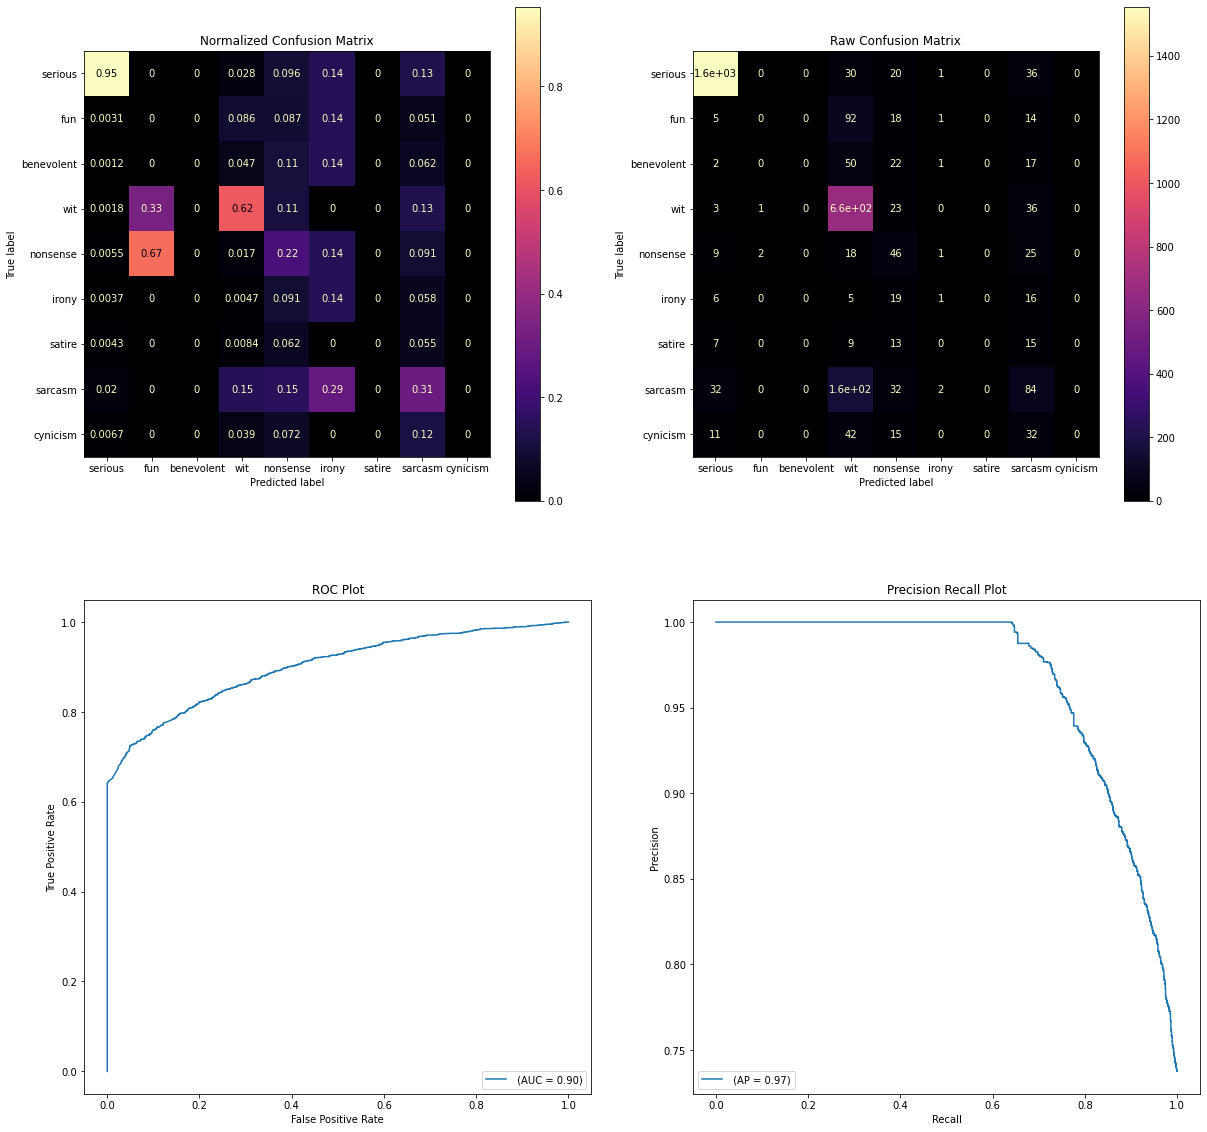

In [46]:
#@title Analyse Results of Training

#@markdown Which type of model is being analysed?
Data_Type = "Humour Type" #@param ["Humour Type", "Humour Degree", "H-Degree (binary)"]

#@markdown To assess the statistical success of the fine-tuning, 3 analyses are conducted using the test data-set:
#@markdown  **TODO** add option for humour degree (0to5) or txype (0to8)

#@markdown * **Confusion Matrix**<br>
#@markdown  A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
#@markdown Here the classifiers are ether humour type or degree of humour. The correctly predicted results (as compared against the expected results in the test data) are
#@markdown those on the diagonal. The numbers within the matrix represent the following four cases
#@markdown * true positives (TP): These are cases in which the trained NLM predicted the correct value (of type or degree)
#@markdown * true negatives (TN): These are cases in which the trained NLM predicted correctly that the value (of type or degree) is not fitting for the test text
#@markdown * false positives (FP): These are cases in which the trained NLM predicted incorrectly that the value (of type or degree) would match for the test text
#@markdown * false negatives (FN): These are cases in which the trained NLM predicted incorrectly that the value (of type or degree) is not fitting for the test text
#@markdown To help with interpretation of the results, the first matrix is additionally normalized according to the proportion of all values for each indicator counted individually for the test run
#@markdown <br>For more details consult 
#@markdown [scikit Confusion Matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

#@markdown * **ROC Curve**<br>
#@markdown  This is a commonly used graph that summarizes the performance of a classifier over all possible thresholds. It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) as you vary the threshold for assigning observations to a given class 
#@markdown <br>For more details consult 
#@markdown [scikit ROC](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

#@markdown * **Precision Recall**<br>
#@markdown  Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 
#@markdown In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
#@markdown The precision-recall curve shows the tradeoff between precision and recall for different threshold. 
#@markdown A high area under the curve represents both high recall and high precision, where high precision relates to a low false 
#@markdown positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results 
#@markdown (high precision), as well as returning a majority of all positive results (high recall).<br>
#@markdown Average precision (**AP**) summarizes such a plot as the weighted mean of precisions achieved at each threshold, 
#@markdown with the increase in recall from the previous threshold used as the weight. <br>For more details consult 
#@markdown [scikit Precision Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

names=['serious','fun','benevolent','wit','nonsense','irony','satire','sarcasm','cynicism']
degree_names=['serious','wry smile','smile','grin','very funny','hilarious']
binary_degree_names=['serious','funny']
clean_h=[]
for val in humour:
  clean_h.append(val.replace('\r',""))
clean_p=[]
pred=test_df['Humour Level'].tolist()[1:len(clean_h)+1:1]
for val in pred:
  clean_p.append(val.replace(' ',"").replace('\r',""))

fig = plt.figure()
cm_n =''
cm = ''
if Data_Type == "Humour Type":
  cm_n=confusion_matrix(clean_p,clean_h, labels=['0','1','2','3','4','5','6','7','8'], normalize= 'pred')
  cm=confusion_matrix(clean_p,clean_h, labels=['0','1','2','3','4','5','6','7','8'])
  cm_n_display = ConfusionMatrixDisplay(cm_n, display_labels=names)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=names)
elif Data_Type == "Humour Degree" :
  cm_n=confusion_matrix(clean_p,clean_h, labels=['0','1','2','3','4','5'], normalize= 'pred')
  cm=confusion_matrix(clean_p,clean_h, labels=['0','1','2','3','4','5'])
  cm_n_display = ConfusionMatrixDisplay(cm_n, display_labels=degree_names)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=degree_names)
else :
  cm_n=confusion_matrix(clean_p,clean_h, labels=['0','1'], normalize= 'pred')
  cm=confusion_matrix(clean_p,clean_h, labels=['0','1'])
  cm_n_display = ConfusionMatrixDisplay(cm_n, display_labels=binary_degree_names)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=binary_degree_names)

fpr, tpr,  _ = roc_curve(y_true, y_score, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
# fig2, ax2 = plt.subplots(figsize=(10,10))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="")

avg_precision = average_precision_score(y_true, y_score)
prec, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall,average_precision=avg_precision,estimator_name="" )

# Try a multi plot :-)
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20))
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

cm_n_display.plot(ax=axs[0,0],cmap='magma')
axs[0,0].set_title('Normalized Confusion Matrix')
cm_display.plot(ax=axs[0,1],cmap='magma')
axs[0,1].set_title('Raw Confusion Matrix')
roc_display.plot(ax=axs[1,0])
axs[1,0].set_title('ROC Plot')
pr_display.plot(ax=axs[1,1])
axs[1,1].set_title('Precision Recall Plot')
# plt.show()

# create image to save to wandb
plotname= "conf_matrix-" + own_modelid + ".png"
plot_dir = "/content/gdrive/MyDrive/ColabNotebooks/Visualization/plots/"
fig.savefig(plot_dir + plotname)

# TODO : extend this to multi-class precision recall. See example here
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py


In [47]:
#@title Calculate Metrics for Precision, Recall and F1

#@markdown Compute precision, recall, F-measure and support for each class <br>The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives
#@markdown * The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
#@markdown * The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. <br>The recall is intuitively the ability of the classifier to find all the positive samples.
#@markdown * The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
#@markdown * The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

#@markdown **NB:** The metrics and image of the Confusion Matrix, ROC plot and Precision/Recall plot are all archived to WandB
# print( "F1 none:",f1_score(clean_h,clean_p, average=None))
from sklearn.metrics import precision_recall_fscore_support
# print( "Prec, Recall, F-Score (macro):",precision_recall_fscore_support(clean_h, clean_p, average='macro'))
# print( "Prec, Recall, F-Score (micro):",precision_recall_fscore_support(clean_h, clean_p, average='micro'))
prf_weighted = precision_recall_fscore_support(clean_h, clean_p, average='weighted')
print( "Prec, Recall, F-Score (weighted):",prf_weighted)
print( "Prec, Recall, F-Score (per category):",precision_recall_fscore_support(clean_h, clean_p, average=None))

# relay metrics to WandB
api = wandb.Api()
# run = api.run("jb-diplom/"+ WandB_Project + "/" + own_modelid)

run_id="jb-diplom/"+ WandB_Project + "/runs/" + own_modelid
run = api.run(run_id)

run.summary["precision"] = prf_weighted[0]
run.summary["recall"] = prf_weighted[1]
run.summary["F1"] = prf_weighted[2]
run.summary.update()

# Send saved image of plots to WandB
# run_id="jb-diplom/"+ WandB_Project + "/" + own_modelid
wandb.init(project=WandB_Project, entity='jb-diplom', id=wandb.Api().run(run_id).id, resume='allow')
im = plt.imread(plot_dir + plotname) # from previous cell
wandb.log({"img": [wandb.Image(im, caption=plotname)]})
wandb.finish()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Prec, Recall, F-Score (weighted): (0.8426722698520799, 0.7364462550924475, 0.7774590771106445, None)
Prec, Recall, F-Score (per category): (array([0.94701583, 0.        , 0.        , 0.9133425 , 0.45544554,
       0.0212766 , 0.        , 0.27272727, 0.        ]), array([0.95398773, 0.        , 0.        , 0.62172285, 0.22115385,
       0.14285714, 0.        , 0.30545455, 0.        ]), array([0.950489  , 0.        , 0.        , 0.73983287, 0.29773463,
       0.03703704, 0.        , 0.28816467, 0.        ]), array([1630,    3,    0, 1068,  208,    7,    0,  275,    0]))


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


train/train_runtime,1276.7329
F1,0.77746
train/total_flos,1.77781221704448e+16
eval/runtime,11.1997
eval/samples_per_second,284.919
train/loss,0.7576
_timestamp,1622153444
_step,53
train/learning_rate,0
eval/accuracy,0.74773
train/global_step,1000


_runtime,▁
_timestamp,▁
_step,▁


In [17]:
# Read in tweets, do humour evaluation and write results back to df and save new csv
#@title Optionally Enter Alternative File Name for Conducting Test{ vertical-output: true, form-width: "50%", display-mode: "form" }

#@markdown #### Specify Source for Humour Tests (skip this if you wish to continue with the results obtained from the previous step)
#@markdown ---

basedir="/content/gdrive/MyDrive/ColabNotebooks/Visualization/msc_data/"#@param {type:"string"}
file_name='comedian-tweets250'#@param {type:"string"}
ext=".csv" #@param {type:"string"}
tweet_file=basedir + file_name + ext
dtyps={'tweetId':str, 'content':str, 'username':str,'followers':int, 'conversationId':str, 
         'replyCount':int, 'retweetCount':int, 'likeCount':int, 'quoteCount':int}

# tweet_df = pd.read_csv(tweet_file, delimiter='\t', header=None, dtype=dtyps,lineterminator='\n',encoding='utf-16')
# tweet_df = pd.read_csv(tweet_file, delimiter='\t', header=None, dtype=dtyps,encoding='utf-16')
# cols=['tweetId', 'content', 'username','followers', 'conversationId', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount']

tweet_df = pd.read_csv(tweet_file, delimiter='\t',encoding='utf-16')
# tweet_df.pop(tweet_df.columns[0])
# tweet_df.pop(tweet_df.columns[3])

tweet_df.head()

,tweetId,content,username,followers,conversationId,replyCount,retweetCount,likeCount,quoteCount
0,1384617849415688192,American police forces were established to cat...,robdelaney,1581288,1384617849415688192,78,455,4774,10
1,1384613550526803969,"Oh my god, I sound so horny as a French person...",WeeMissBea,508964,1384613550526803969,55,21,1016,1
2,1384597084448464906,Take down immediatejt https://t.co/CiVIQEfo1V,robdelaney,1581288,1384597084448464906,17,46,1702,1
3,1384498297381945346,https://t.co/6jKt6gC87Z,robdelaney,1581288,1384498297381945346,34,32,623,5
4,1384482731464138758,Susan's #CatofTheDay is Happ.\n\nThank you @Fr...,SusanCalman,260039,1384482731464138758,15,24,1138,1


In [ ]:
use_all_samples = False #@param {type:"boolean"}
sample_nr = 1210 #@param {type:"slider", min:10, max:5000, step:10}
output_max= sample_nr

if use_all_samples:
  sample_nr = -1
  output_max = len(tweet_df)



In [ ]:
#@title Evaluate in Pipeline and Save (sample nr. or all) Results to GDrive
#@markdown The results are added as column ***Humour*** to the test (input) data and are saved with a suffix (the model name) as `.tsv` file in the same directory

content=tweet_df.iloc[:,1]  # grab the content column (it should be the 2nd)
humour=[]

for tweet in tqdm(content.head(sample_nr)):
  humour.append(humour_classif(tweet)[0]['label'])

hlen=len(humour)
for i in range (hlen, len(tweet_df)):
  humour.append("not evaluated")

# add humour column to dataframe
tweet_df['Humour']=humour

# save results
tweet_file_out=basedir + file_name +'_' + model_id + ext
print ("Saving to:", tweet_file_out)

# tweet_df.to_csv(tweet_file_out, sep='\t', index=False, lineterminator='\n',encoding='utf-16')
tweet_df.to_csv(tweet_file_out, sep='\t', index=False,encoding='utf-16')

data_table.DataTable(tweet_df.head(min(sample_nr,20000)), include_index=False, num_rows_per_page=10)

In [ ]:
#@title Display distribution of data for each type of humour
vc=tweet_df['Humour'].value_counts()
vc

In [ ]:
#@markdown Display resulting data
tweet_df = tweet_df.dropna()
subdf=tweet_df.query("Humour!='not evaluated' & likeCount > 5000")
data_table.DataTable(subdf.head(20000), include_index=False, num_rows_per_page=10)

In [ ]:
#@title Choose Sample of Data for Visualization

# limit of absolute_max=20000 due to colab DataTable

import warnings
absolute_max=20000

names=['serious','fun','benevolent','wit','nonsense','irony','satire','sarcasm','cynicism']
as_many_as_possible = True #@param {type:"boolean"}
sample = 5000 #@param {type:"slider", min:100, max:20000, step:100}
op_max= sample

if as_many_as_possible:
  op_max = 20000

likes_sorted=np.sort(tweet_df['likeCount'])
num_tweets=len(tweet_df)
divisor = min (absolute_max, op_max)

last_like=0
if absolute_max < num_tweets:
  chunk_lst=np.array_split(likes_sorted,int(num_tweets/divisor))
  last_like=int(chunk_lst[-1][0])

tweet_df = tweet_df.dropna()
subdf=tweet_df.loc[(tweet_df['Humour'] !='not evaluated') & (tweet_df['likeCount'] > last_like)]

# add line breaks to make tooltips readable
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subdf.content = subdf.content.str.wrap(80)
    subdf.content = subdf.content.apply(lambda x: x.replace('\n', '<br>'))

fig1 = px.scatter(subdf, x="retweetCount", y="username", size="likeCount",
                 color="Humour", hover_name="content", facet_col="Humour", size_max=100, log_x=True, 
                 category_orders = {'Humour': ['LABEL_0','LABEL_1','LABEL_2','LABEL_3','LABEL_4','LABEL_5','LABEL_6','LABEL_7','LABEL_8']},
                 color_discrete_sequence=color_palette, height=3000,opacity=0.6, facet_col_wrap=3)
fig1.update_layout(
    plot_bgcolor=plot_bgcolor,
    title="Tweet Distribution per Humour Type amongst leading Twitterers",
    xaxis_title="Retweets (log-scale)",
    yaxis_title="Twitter Handles",
  )
fig1.show()

In [ ]:
#@title Calculate averages 
#@markdown * For each type of Tweet propagation (reply, retweet, like, quote) 
#@markdown * And each humour type

table = pd.pivot_table(tweet_df, values=['replyCount', 'retweetCount', 'likeCount', 'quoteCount'], index=['Humour'],
                    aggfunc={'replyCount': np.mean,
                             'retweetCount': np.mean,
                             'likeCount': np.mean,
                             'quoteCount': np.mean
                             })
table=table.loc[(table.index != "not evaluated")]

# need to rotate 'replyCount', 'retweetCount', 'likeCount', 'quoteCount' into one column and put the averages in a new column
dic ={"humour":[], "propagation type":[],"mean value":[]}
for htype in table.iterrows():
  for i in range (0,4) : dic["humour"].append(htype[0])
  dic["propagation type"].append('likes')
  dic["mean value"].append(int(htype[1]['likeCount']))
  dic["propagation type"].append('quotes')
  dic["mean value"].append(int(htype[1]['quoteCount']))
  dic["propagation type"].append('replies')
  dic["mean value"].append(int(htype[1]['replyCount']))
  dic["propagation type"].append('retweets')
  dic["mean value"].append(int(htype[1]['retweetCount']))

df_avg=pd.DataFrame(dic)

df_avg.head(10)

In [ ]:
#@title Visualize average numbers of Tweet propagations per humour type
from plotly.graph_objs import *

# labels={'Humour': ['LABEL_0','LABEL_1','LABEL_2','LABEL_3','LABEL_4','LABEL_5','LABEL_6','LABEL_7','LABEL_8'],
#                                       'propagation type': ['quotes','replies','retweets','likes']}
labels={'Humour': "",'propagation type': ''}
fig = px.histogram(df_avg, 
                   x='propagation type', 
                   y='mean value', 
                   facet_col="humour",
                   histfunc ='avg',
                   color_discrete_sequence=color_palette_r,
                   color='propagation type',
                  #  barmode='group',
                   category_orders = {'Humour': ['LABEL_0','LABEL_1','LABEL_2','LABEL_3','LABEL_4','LABEL_5','LABEL_6','LABEL_7','LABEL_8'],
                                      'propagation type': ['likes','retweets','replies','quotes']},
                   labels=labels
                   )
fig.update_xaxes(type='category')

fig.update_layout(
    plot_bgcolor=plot_bgcolor,
    title="Average Numbers of Tweet Propagations per Humour Type",
    xaxis_title="",
    yaxis_title="Average Numbers of Tweet Propagations",
    # legend_title="Legend Title"
  )
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()

In [ ]:
#@markdown ##Visualize Distribution of Tweets per Twitter-Handle
#@markdown Select/deselect humour types in the legend to analyse deeper

subdf2=tweet_df.query("Humour!='not evaluated'")
s = subdf2.groupby("username")["followers"].sum().rank(ascending=True)
# s = subdf2.groupby("username").size().reset_index().groupby(['replyCount', 'retweetCount', 'likeCount', 'quoteCount']).sum().rank(ascending=True)


fig = px.histogram(subdf2, 
                   x='username',
                   color="Humour",
                   color_discrete_sequence=color_palette_r,
                   category_orders = {'Humour': ['LABEL_0','LABEL_1','LABEL_2','LABEL_3','LABEL_4','LABEL_5','LABEL_6','LABEL_7','LABEL_8'],
                                      'propagation type': ['likes','retweets','replies','quotes'],
                                      "username":s[s < 100000].sort_values().index.to_list()},
                   orientation='v', height=800
                      )
fig.update_layout(
    plot_bgcolor=plot_bgcolor,
    title="Numbers of Tweets amongst leading Twitterers",
    )
fig.show()

# Neuer Abschnitt

# Utility Code





In [ ]:
# Invoke to show what gpu is in use
gpu = !nvidia-smi
gpu = '\n'.join(gpu)
print(gpu)

In [ ]:
%env
!python '/content/gdrive/MyDrive/ColabNotebooks/Visualization/run_glue2.py' --help
train_file.value

## Visualization of results in dashboard
Analyze results (as they happen) on the project dashboard https://wandb.ai/jb-diplom/janice-demo

### To retrieve models and their metadata from wandb

1.   Go to the artifacts area of wandb (e.g. `https://wandb.ai/jb-diplom/janice-full/artifacts`)
2.   Select the API Tag, which gives the precise code (below) for downloading the model that you need.
3.   Check in the artifacts folder of Colab for the sub-folder (e.g. `model-12ai5jvy:0`) with the model.<br> Right-click it and take a copy of the path
4.   Use the path in the huggingface pipeline constructor e.g.<br>
`model_path="/content/artifacts/model-15ai5jvy:v0"`
`humour_classiffier = pipeline('sentiment-analysis',model_path)`


In [ ]:
# Display W & B Destop for 
# own_modelid='electra-L-htype_balanced20e2021-05-16_07.13.44'
run_id="jb-diplom/"+ WandB_Project + "/" + own_modelid
print(run_id)
run=wandb.init(project=WandB_Project, entity='jb-diplom', id=wandb.Api().run(run_id).id, resume='allow')
run